<a href="https://colab.research.google.com/github/konatesouley/Chest_X-Ray_Images_Pneumonia_kaggle/blob/main/Projet_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray Images (Pneumonia)

# Contexte
http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5



Figure S6. Exemples illustratifs de radiographies pulmonaires chez des patients atteints de pneumonie, liés à
la figure 6 La radiographie pulmonaire normale (panneau de gauche) représente des poumons clairs sans aucune zone d’opacification anormale dans l’image. La pneumonie bactérienne (au milieu) présente généralement une consolidation lobaire focale, dans ce cas dans le lobe supérieur droit (flèches blanches), tandis que la pneumonie virale (à droite) se manifeste par un schéma « interstitiel » plus diffus dans les deux poumons.
http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

## Contenu
Le jeu de données est organisé en 3 dossiers (train, test, val) et contient des sous-dossiers pour chaque catégorie d’image (Pneumonie/Normal). Il y a 5 863 images radiographiques (JPEG) et 2 catégories (pneumonie/normale).

Les radiographies thoraciques (antéro-postérieures) ont été sélectionnées à partir de cohortes rétrospectives de patients pédiatriques âgés de un à cinq ans du Guangzhou Women and Children’s Medical Center, Guangzhou. Toutes les radiographies pulmonaires ont été effectuées dans le cadre des soins cliniques de routine des patients.

Pour l’analyse des radiographies pulmonaires, toutes les radiographies pulmonaires ont d’abord été examinées pour le contrôle de la qualité en supprimant tous les scans de faible qualité ou illisibles. Les diagnostics des images ont ensuite été notés par deux médecins experts avant d’être autorisés à former le système d’IA. Afin de tenir compte des éventuelles erreurs de notation, l’ensemble d’évaluation a également été vérifié par un troisième expert.

## Objectif
Dans cette étude, nous allons chercher à développer un algorithme d’apprentissage (par transfert) efficace pour traiter les images médicales afin de fournir un diagnostic précis et opportun de la pathologie clé dans chaque image. L’illustration principale de cette technique impliquait des images de tomographie par cohérence optique (OCT) du thorace.

# Chargement des données

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"konatesouleymane","key":"cf20b25176694f6759e8e80c668e3421"}'}

In [2]:
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

-rw-r--r-- 1 root root 72 Mar 21 11:02 kaggle.json
/content


In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:12<00:00, 205MB/s]
100% 2.29G/2.29G [00:12<00:00, 202MB/s]


In [5]:
!unzip -q /content/chest-xray-pneumonia.zip

In [6]:
%%capture
!pip install transformers

In [7]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import TFAutoModelForImageClassification
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
batch_size = 32
img_height = 160
img_width = 160

## Base de train, val et test

In [9]:
## Base de train
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/chest_xray/train",
  image_size=(img_height, img_width),
  batch_size=batch_size,)

## Base de validatation
val_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/chest_xray/chest_xray/val",
  image_size=(img_height, img_width),
  batch_size=batch_size)

## Base de test
test_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/chest_xray/chest_xray/test",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [10]:
class_names = train_ds.class_names

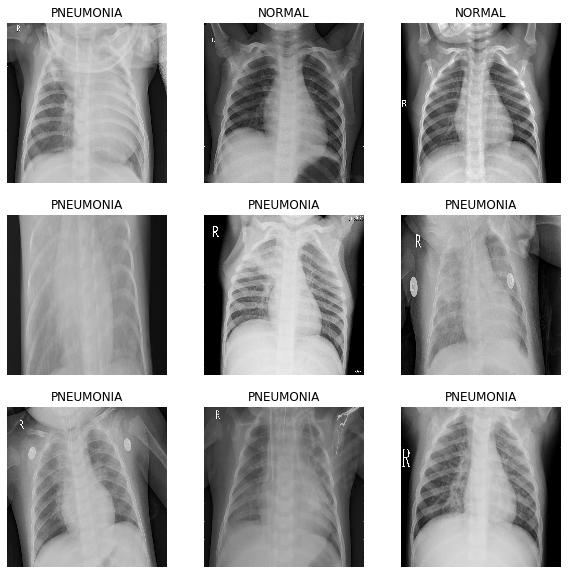

In [11]:
# Afficher les 9 premières images avec leur étiquette avant les pré-traitements
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [16]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [18]:
base_model.trainable = False

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

1/1 [==============================] - 2s 2s/step - loss: 0.9937 - accuracy: 0.2500


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.99
initial accuracy: 0.25


In [25]:
# Définir le callback ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor='val_accuracy',
    verbose=1,
    #save_best_only=True,
    #save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    callbacks=[checkpoint],
                    validation_data=validation_dataset)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

20/20 [==============================] - 3s 84ms/step - loss: 0.5114 - accuracy: 0.7708
Test accuracy : 0.7708333134651184


Predictions:
 [1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1]
Labels:
 [1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0]


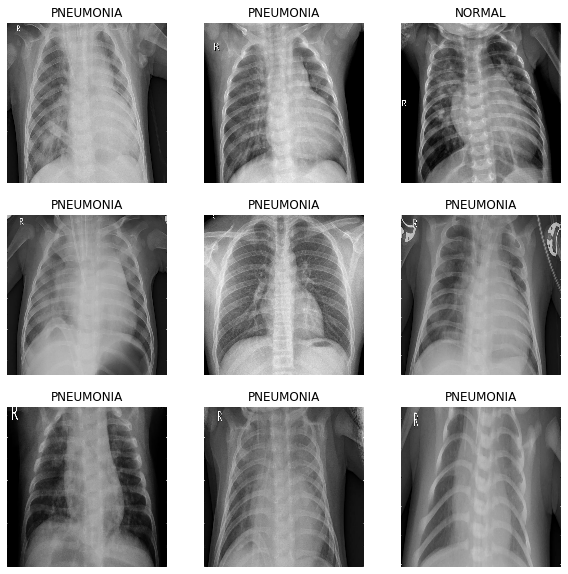

In [29]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# L'application Gradio

In [ ]:
import gradio as gr
from transformers import pipeline

# Charger le modèle de classification d'images ViT de Hugging Face
classifier = pipeline("image-classification", model="content/best_model.h5", device=0)

# Définir la fonction de prédiction
def classify_image(img):
    prediction = classifier(img)
    label = prediction[0]['label']
    score = prediction[0]['score']
    return f"Label: {label}, Score: {score:.2f}"

# Définir l'interface utilisateur Gradio
input_image = gr.inputs.Image()
output_label = gr.outputs.Textbox()
interface = gr.Interface(fn=classify_image, inputs=input_image, outputs=output_label, title="best_model.h5 Classification")

# Lancer l'interface utilisateur Gradio
interface.launch()